In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from fastcore.xtras import load_pickle
from guacamol.utils.chemistry import is_valid
from fastcore.foundation import L 
from gptchem.data import get_photoswitch_data
from gptchem.evaluator import evaluate_generated_smiles, evaluate_photoswitch_smiles_pred, is_in_pubchem, predict_photoswitch, get_regression_metrics
from gptchem.settings import ONE_COL_GOLDEN_RATIO_HEIGHT_INCH, ONE_COL_WIDTH_INCH
from rdkit.Contrib.SA_Score.sascorer import calculateScore as calculate_sascore
from rdkit import Chem 

from scipy.stats import sem

import matplotx
import numpy as np 

from gptchem.plotsettings import *

%matplotlib inline

In [3]:
def get_sa_scores(smiles):
    sa_scores = []
    for smiles in smiles:
        try:
            mol = Chem.MolFromSmiles(smiles)
            sa_scores.append(calculate_sascore(mol))
        except: 
            pass
    return sa_scores

In [4]:
from rdkit import Chem

In [5]:
all_res = glob("out/**/*.pkl")

In [6]:
res = load_pickle(all_res[0])

In [7]:
from collections import defaultdict

In [8]:
def contains_azo(smiles):
    mol = Chem.MolFromSmiles(smiles)
    # check if there is a N#N bond
    smarts = "[NX2]=N"
    return mol.HasSubstructMatch(Chem.MolFromSmarts(smarts))

In [9]:
compiled_res = []
generated_smiles = set()
generated_smiles_w_azos = set()

generated_smiles_w_azos_at_temp = defaultdict(set)
generated_smiles_at_temp = defaultdict(set)

for res_path in all_res:
    res = load_pickle(res_path)
    for temp_res in res["res_at_temp"]:
        try:
            generated_smiles_ = [s.split()[0] for s in temp_res["generated_smiles"]]
            in_train_smiles = []
            novel_indices = []
            for i, s in enumerate(temp_res["valid_smiles"]):
                s = s.split()[0]
                if s in temp_res["train_smiles"].values:
                    in_train_smiles.append(s)
                else:
                    novel_indices.append(i)
            metrics = {
                "noise_level": res["noise_level"],
                "temp": temp_res["temperature"],
                "frac_valid": temp_res["frac_valid"],
                "frac_unique": temp_res["frac_unique"],
                 "frac_smiles_in_train": len(in_train_smiles) / len(temp_res["valid_smiles"]),
                "frac_smiles_in_pubchem": sum([is_in_pubchem(s.split()[0]) for s in temp_res["valid_smiles"]]) / len(temp_res["valid_smiles"]), 
                "kld": temp_res["kld"],
                "frechet_d": temp_res["frechet_d"],
                "frechet_score": temp_res["frechet_score"],
                "frac_contains_azo": sum([contains_azo(s) for s in temp_res["valid_smiles"]])
                / len(temp_res["valid_smiles"]),
            }
            valid_smiles = [s for s in generated_smiles_ if is_valid(s)]
            generated_smiles.update(valid_smiles)
            v_w_azo = [s for s in generated_smiles_ if is_valid(s) and contains_azo(s)]
            if temp_res['temperature']  == 2.0:
                print(get_sa_scores(v_w_azo) )
            metrics['sa_score'] = np.nanmean([score for score in get_sa_scores(v_w_azo) if isinstance(score, float)])
         
            generated_smiles_w_azos.update(v_w_azo)
            generated_smiles_w_azos_at_temp[temp_res["temperature"]].update(v_w_azo)

            valid = [s for s in generated_smiles_ if is_valid(s)]
            generated_smiles_at_temp[temp_res["temperature"]].update(valid)

            pred_e, pred_z = [], []
            for s in valid:
                e, z = predict_photoswitch(s)
                pred_e.append(e[0][0])
                pred_z.append(z[0][0])

            pred_e = L(pred_e)
            pred_z = L(pred_z)

            expected_e = L(temp_res["constrain_satisfaction"]["expected_e_pi_pi_star"])
            expected_z = L(temp_res["constrain_satisfaction"]["expected_z_pi_pi_star"])

            v = [s for s in temp_res["generated_smiles"] if is_valid(s)]
            generated_smiles_at_temp[temp_res["temperature"]].update(v)

            for me, v in get_regression_metrics(expected_e, pred_e).items():
                metrics["e_pi_pi_star_" + me] = v

            for me, v in get_regression_metrics(expected_z, pred_z).items():
                metrics["z_pi_pi_star_" + me] = v

            for me, v in get_regression_metrics(
                expected_e[novel_indices], pred_e[novel_indices]
            ).items():
                metrics["e_pi_pi_star_novel_" + me] = v

            for me, v in get_regression_metrics(
                expected_z[novel_indices], pred_z[novel_indices]
            ).items():
                metrics["z_pi_pi_star_novel_" + me] = v

            
            compiled_res.append(metrics)

        except Exception as e:
            print(e)
            pass

[]
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
[2.7963638599637175, 4.299873485100422, 2.7126161676560248, 4.235192233679319]
'expected_e_pi_pi_star'
[2.7028253984252544, 2.572514514152754, 2.942225398425254, 4.765615030532278, 3.9126435049174795]
'expected_e_pi_pi_star'
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
[]
'PUGREST.BadRequest: error: '
'PUGREST.BadRequest: error: '
[2.645390598096361, 2.7173207830406394]
'expected_e_pi_pi_star'
[]
'PUGREST.BadRequest: error: '
[]
'PUGREST.BadRequest: error: '
[]
'PUGREST.BadRequest: error: '
[]
[]


In [10]:
get_sa_scores(['CC1=NOC(C)=C1/N=N/C2=CC(Br)=CC=C2', 'CC1=C(CC)C=C1/N=N/C2=C(Br)C=C2', 'CC1=C(C(C)=NN1)/N=N/C2=C(Cl)C=CC=C2', 'CC1=C(C(C)=NN1)/N=N/C2=CC(C)C=C2'])

[2.7963638599637175, 4.299873485100422, 2.7126161676560248, 4.235192233679319]

In [11]:
contains_azo(list(generated_smiles)[5])

True

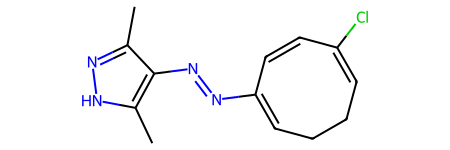

In [12]:
Chem.MolFromSmiles(list(generated_smiles)[0])

In [13]:
df = pd.DataFrame(compiled_res)

In [18]:
df['e_pi_pi_star_novel_mean_absolute_percentage_error'].mean() * 100

10.490725869277744

In [19]:
df['z_pi_pi_star_novel_mean_absolute_percentage_error'].mean() * 100

6.756264193472616

In [ ]:
grouped = df.groupby(["temp"]).agg(["mean", "std", sem, 'count'])

In [ ]:
list(grouped.columns)

In [ ]:
grouped['sa_score']

,mean,std,sem,count
temp,,,,
0.00,2.636467,0.036916,0.015071,6
0.10,2.637233,0.034213,0.013967,6
0.20,2.638344,0.029065,0.011866,6
0.50,2.681208,0.021050,0.008593,6
0.75,2.695959,0.033106,0.013515,6
1.00,2.793606,0.037096,0.015144,6
1.25,2.936699,0.087463,0.035707,6
1.50,3.464627,0.312997,0.127780,6
2.00,NaN,NaN,NaN,0


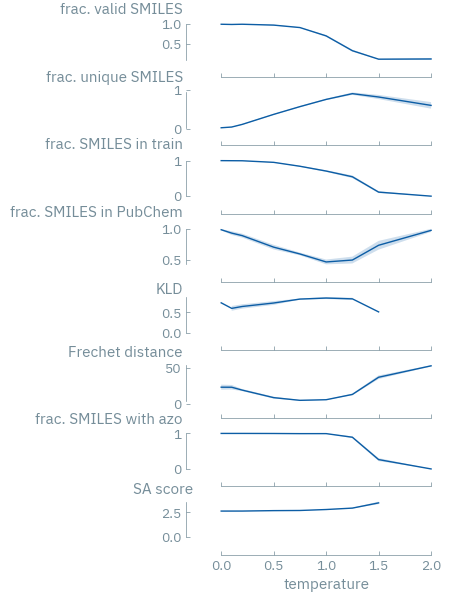

In [ ]:
fig, ax = plt.subplots(8, 1, sharex="col", figsize=(ONE_COL_WIDTH_INCH, 2 * ONE_COL_WIDTH_INCH))
ax[0].plot(grouped.index, grouped["frac_valid"]["mean"], label="frac_valid")
ax[0].fill_between(
    grouped.index,
    grouped["frac_valid"]["mean"] - grouped["frac_valid"]["sem"],
    grouped["frac_valid"]["mean"] + grouped["frac_valid"]["sem"],
    alpha=0.2,
)

ylabel_top("frac. valid SMILES", ax=ax[0], x_pad=0.05,  y_pad=-0.02)

range_frame(
    ax[0],
    grouped.index,
    np.nan_to_num(
        np.stack(
            [
                grouped["frac_valid"]["mean"] - grouped["frac_valid"]["sem"],
                grouped["frac_valid"]["mean"] + grouped["frac_valid"]["sem"],
            ]
        ).flatten(),
        grouped["frac_valid"]["mean"].mean(),
    ),
)

ax[1].plot(grouped.index, grouped["frac_unique"]["mean"], label="frac_unique")
ax[1].fill_between(
    grouped.index,
    grouped["frac_unique"]["mean"] - grouped["frac_unique"]["sem"],
    grouped["frac_unique"]["mean"] + grouped["frac_unique"]["sem"],
    alpha=0.2,
)

range_frame(
    ax[1],
    grouped.index,
    np.nan_to_num(
        np.stack(
            [
                grouped["frac_unique"]["mean"] - grouped["frac_unique"]["sem"],
                grouped["frac_unique"]["mean"] + grouped["frac_unique"]["sem"],
            ]
        ).flatten(),
        grouped["frac_unique"]["mean"].mean(),
    ),
)

ylabel_top("frac. unique SMILES", ax=ax[1], x_pad=0.05)

ax[2].plot(grouped.index, grouped["frac_smiles_in_train"]["mean"], label="frac_smiles_in_train")
ax[2].fill_between(
    grouped.index,
    grouped["frac_smiles_in_train"]["mean"] - grouped["frac_smiles_in_train"]["sem"],
    grouped["frac_smiles_in_train"]["mean"] + grouped["frac_smiles_in_train"]["sem"],
    alpha=0.2,
)

ylabel_top("frac. SMILES in train", ax=ax[2], x_pad=0.05)

range_frame(
    ax[2],
    grouped.index,
    np.nan_to_num(
        np.stack(
            [
                grouped["frac_smiles_in_train"]["mean"] - grouped["frac_smiles_in_train"]["sem"],
                grouped["frac_smiles_in_train"]["mean"] + grouped["frac_smiles_in_train"]["sem"],
            ]
        ).flatten(),
        grouped["frac_smiles_in_train"]["mean"].mean(),
    ),
)


ax[3].plot(grouped.index, grouped["frac_smiles_in_pubchem"]["mean"], label="frac_smiles_in_pubchem")
ax[3].fill_between(
    grouped.index,
    grouped["frac_smiles_in_pubchem"]["mean"] - grouped["frac_smiles_in_pubchem"]["sem"],
    grouped["frac_smiles_in_pubchem"]["mean"] + grouped["frac_smiles_in_pubchem"]["sem"],
    alpha=0.2,
)

ylabel_top("frac. SMILES in PubChem", ax=ax[3], x_pad=0.05,  y_pad=0.02)


range_frame(
    ax[3],
    grouped.index,
    np.nan_to_num(
        np.stack(
            [
                grouped["frac_smiles_in_pubchem"]["mean"]
                - grouped["frac_smiles_in_pubchem"]["sem"],
                grouped["frac_smiles_in_pubchem"]["mean"]
                + grouped["frac_smiles_in_pubchem"]["sem"],
            ]
        ).flatten(),
        grouped["frac_smiles_in_pubchem"]["mean"].mean(),
    ),
)


ax[4].plot(grouped.index, grouped["kld"]["mean"], label="kld")
ax[4].fill_between(
    grouped.index,
    grouped["kld"]["mean"] - grouped["kld"]["sem"],
    grouped["kld"]["mean"] + grouped["kld"]["sem"],
    alpha=0.2,
)

ylabel_top("KLD", ax=ax[4], x_pad=0.05,  y_pad=0.05)



range_frame(
    ax[4],
    grouped.index,
    np.nan_to_num(
        np.stack(
            [
                grouped["kld"]["mean"]
                - grouped["kld"]["sem"],
                grouped["kld"]["mean"]
                + grouped["kld"]["sem"],
            ]
        ).flatten(),
        grouped["kld"]["mean"].mean(),
    ),
)



ax[5].plot(grouped.index, grouped["frechet_d"]["mean"], label="frechet_d")
ax[5].fill_between(
    grouped.index,
    grouped["frechet_d"]["mean"] - grouped["frechet_d"]["sem"],
    grouped["frechet_d"]["mean"] + grouped["frechet_d"]["sem"],
    alpha=0.2,
)

ylabel_top("Frechet distance", ax=ax[5], x_pad=0.05,  y_pad=0.02)



range_frame(
    ax[5],
    grouped.index,
    np.nan_to_num(
        np.stack(
            [
                grouped["frechet_d"]["mean"]
                - grouped["frechet_d"]["sem"],
                grouped["frechet_d"]["mean"]
                + grouped["frechet_d"]["sem"],
            ]
        ).flatten(),
        grouped["frechet_d"]["mean"].mean(),
    ),
)



ax[6].plot(grouped.index, grouped["frac_contains_azo"]["mean"], label="frechet_score")
ax[6].fill_between(
    grouped.index,
    grouped["frac_contains_azo"]["mean"] - grouped["frac_contains_azo"]["sem"],
    grouped["frac_contains_azo"]["mean"] + grouped["frac_contains_azo"]["sem"],
    alpha=0.2,
)

ylabel_top("frac. SMILES with azo", ax=ax[6], x_pad=0.05, y_pad=-0.03)

range_frame(
    ax[6],
    grouped.index,
    np.nan_to_num(
        np.stack(
            [
                grouped["frac_contains_azo"]["mean"]
                - grouped["frac_contains_azo"]["sem"],
                grouped["frac_contains_azo"]["mean"]
                + grouped["frac_contains_azo"]["sem"],
            ]
        ).flatten(),
        grouped["frac_contains_azo"]["mean"].mean(),
    ),
)

ax[7].plot(grouped.index, grouped["sa_score"]["mean"], label="frechet_score")
ax[7].fill_between(
    grouped.index,
    grouped["sa_score"]["mean"] - grouped["sa_score"]["sem"],
    grouped["sa_score"]["mean"] + grouped["sa_score"]["sem"],
    alpha=0.2,
)

ylabel_top("SA score", ax=ax[7])

range_frame(
    ax[7],
    grouped.index,
    np.nan_to_num(
        np.stack(
            [
                grouped["sa_score"]["mean"]
                - grouped["sa_score"]["sem"],
                grouped["sa_score"]["mean"]
                + grouped["sa_score"]["sem"],
            ]
        ).flatten(),
        grouped["sa_score"]["mean"].mean(),
    ),
)



ax[-1].set_xlabel("temperature", labelpad=4)

plt.subplots_adjust(hspace=0.6, top=1, bottom=0.2)

fig.savefig("photoswitch_random_smiles_metrics_full.pdf", bbox_inches="tight")

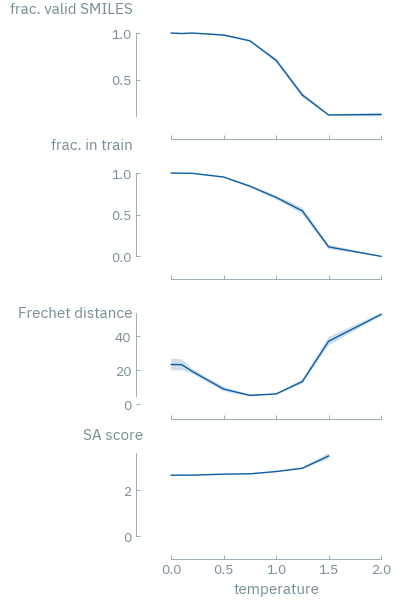

In [ ]:
fig, ax = plt.subplots(4, 1, sharex="col", figsize=(ONE_COL_WIDTH_INCH, 2 * ONE_COL_WIDTH_INCH))
ax[0].plot(grouped.index, grouped["frac_valid"]["mean"], label="frac_valid")
ax[0].fill_between(
    grouped.index,
    grouped["frac_valid"]["mean"] - grouped["frac_valid"]["sem"],
    grouped["frac_valid"]["mean"] + grouped["frac_valid"]["sem"],
    alpha=0.2,
)

ylabel_top("frac. valid SMILES", ax=ax[0], x_pad=0.05,  y_pad=-0.02)

range_frame(
    ax[0],
    grouped.index,
    np.nan_to_num(
        np.stack(
            [
                grouped["frac_valid"]["mean"] - grouped["frac_valid"]["sem"],
                grouped["frac_valid"]["mean"] + grouped["frac_valid"]["sem"],
            ]
        ).flatten(),
        grouped["frac_valid"]["mean"].mean(),
    ),
)

ax[1].plot(grouped.index, grouped["frac_smiles_in_train"]["mean"], label="frac_smiles_in_train")
ax[1].fill_between(
    grouped.index,
    grouped["frac_smiles_in_train"]["mean"] - grouped["frac_smiles_in_train"]["sem"],
    grouped["frac_smiles_in_train"]["mean"] + grouped["frac_smiles_in_train"]["sem"],
    alpha=0.2,
)

ylabel_top("frac. in train", ax=ax[1], x_pad=0.05)

range_frame(
    ax[1],
    grouped.index,
    np.nan_to_num(
        np.stack(
            [
                grouped["frac_smiles_in_train"]["mean"] - grouped["frac_smiles_in_train"]["sem"],
                grouped["frac_smiles_in_train"]["mean"] + grouped["frac_smiles_in_train"]["sem"],
            ]
        ).flatten(),
        grouped["frac_smiles_in_train"]["mean"].mean(),
    ),
)


ax[2].plot(grouped.index, grouped["frechet_d"]["mean"], label="frechet_d")
ax[2].fill_between(
    grouped.index,
    grouped["frechet_d"]["mean"] - grouped["frechet_d"]["sem"],
    grouped["frechet_d"]["mean"] + grouped["frechet_d"]["sem"],
    alpha=0.2,
)

ylabel_top("Frechet distance", ax=ax[2], x_pad=0.05,  y_pad=0.02)


range_frame(
    ax[2],
    grouped.index,
    np.nan_to_num(
        np.stack(
            [
                grouped["frechet_d"]["mean"]
                - grouped["frechet_d"]["sem"],
                grouped["frechet_d"]["mean"]
                + grouped["frechet_d"]["sem"],
            ]
        ).flatten(),
        grouped["frechet_d"]["mean"].mean(),
    ),
)


ax[3].plot(grouped.index, grouped["sa_score"]["mean"], label="frechet_score")
ax[3].fill_between(
    grouped.index,
    grouped["sa_score"]["mean"] - grouped["sa_score"]["sem"],
    grouped["sa_score"]["mean"] + grouped["sa_score"]["sem"],
    alpha=0.2,
)

ylabel_top("SA score", ax=ax[3])

range_frame(
    ax[3],
    grouped.index,
    np.nan_to_num(
        np.stack(
            [
                grouped["sa_score"]["mean"]
                - grouped["sa_score"]["sem"],
                grouped["sa_score"]["mean"]
                + grouped["sa_score"]["sem"],
            ]
        ).flatten(),
        grouped["sa_score"]["mean"].mean(),
    ),
)



ax[-1].set_xlabel("temperature", labelpad=4)

plt.subplots_adjust(hspace=0.4, top=1, bottom=0.2)

fig.savefig("photoswitch_random_smiles_metrics_subset.pdf", bbox_inches="tight")

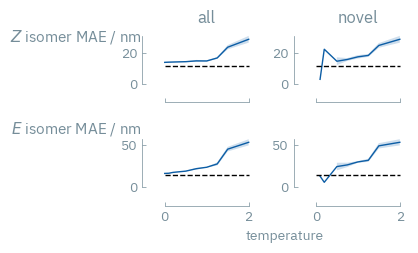

In [75]:
# with plt.style.context(matplotx.styles.dufte):
fig, ax = plt.subplots(
    2, 2, sharex="all", figsize=(ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH)
)

ax[0][0].plot(
    grouped.index,
    grouped["z_pi_pi_star_mean_absolute_error"]["mean"],
    label="e_pi_pi_star_metrics",
)
ax[0][0].fill_between(
    grouped.index,
    grouped["z_pi_pi_star_mean_absolute_error"]["mean"]
    - grouped["z_pi_pi_star_mean_absolute_error"]["sem"],
    grouped["z_pi_pi_star_mean_absolute_error"]["mean"]
    + grouped["z_pi_pi_star_mean_absolute_error"]["sem"],
    alpha=0.2,
)

ax[0][1].plot(
    grouped.index,
    grouped["z_pi_pi_star_novel_mean_absolute_error"]["mean"],
    label="e_pi_pi_star_metrics",
)
ax[0][1].fill_between(
    grouped.index,
    grouped["z_pi_pi_star_novel_mean_absolute_error"]["mean"]
    - grouped["z_pi_pi_star_novel_mean_absolute_error"]["sem"],
    grouped["z_pi_pi_star_novel_mean_absolute_error"]["mean"]
    + grouped["z_pi_pi_star_novel_mean_absolute_error"]["sem"],
    alpha=0.2,
)

range_frame(
    ax[0][0],
    grouped.index,
    np.stack(
        [
            np.append(
                np.nan_to_num(
                    np.stack(
                        [
                            grouped["z_pi_pi_star_novel_mean_absolute_error"]["mean"]
                            - grouped["z_pi_pi_star_novel_mean_absolute_error"]["sem"],
                            grouped["z_pi_pi_star_novel_mean_absolute_error"]["mean"]
                            + grouped["z_pi_pi_star_novel_mean_absolute_error"]["sem"],
                        ]
                    ).flatten(),
                    grouped["z_pi_pi_star_novel_mean_absolute_error"]["mean"].mean(),
                ),
                11.616605626696359,
            ),
            np.append(
                np.nan_to_num(
                    np.stack(
                        [
                            grouped["z_pi_pi_star_mean_absolute_error"]["mean"]
                            - grouped["z_pi_pi_star_mean_absolute_error"]["sem"],
                            grouped["z_pi_pi_star_mean_absolute_error"]["mean"]
                            + grouped["z_pi_pi_star_mean_absolute_error"]["sem"],
                        ]
                    ).flatten(),
                    grouped["z_pi_pi_star_mean_absolute_error"]["mean"].mean(),
                ),
                11.616605626696359,
            ),
        ]
    ),
)


range_frame(
    ax[0][1],
    grouped.index,
    np.stack(
        [
            np.append(
                np.nan_to_num(
                    np.stack(
                        [
                            grouped["z_pi_pi_star_novel_mean_absolute_error"]["mean"]
                            - grouped["z_pi_pi_star_novel_mean_absolute_error"]["sem"],
                            grouped["z_pi_pi_star_novel_mean_absolute_error"]["mean"]
                            + grouped["z_pi_pi_star_novel_mean_absolute_error"]["sem"],
                        ]
                    ).flatten(),
                    grouped["z_pi_pi_star_novel_mean_absolute_error"]["mean"].mean(),
                ),
                11.616605626696359,
            ),
            np.append(
                np.nan_to_num(
                    np.stack(
                        [
                            grouped["z_pi_pi_star_mean_absolute_error"]["mean"]
                            - grouped["z_pi_pi_star_mean_absolute_error"]["sem"],
                            grouped["z_pi_pi_star_mean_absolute_error"]["mean"]
                            + grouped["z_pi_pi_star_mean_absolute_error"]["sem"],
                        ]
                    ).flatten(),
                    grouped["z_pi_pi_star_mean_absolute_error"]["mean"].mean(),
                ),
                11.616605626696359,
            ),
        ]
    ),
),

# ylabel_top("MAE / nm", ax=ax[0][0])

ax[0][0].hlines(11.616605626696359, 0, 2, color="k", linestyle="--")
ax[0][1].hlines(11.616605626696359, 0, 2, color="k", linestyle="--")
# ax[0].set_ylim(8, 35)

ax[1][0].plot(
    grouped.index,
    grouped["e_pi_pi_star_mean_absolute_error"]["mean"],
    label="e_pi_pi_star_metrics",
)
ax[1][0].fill_between(
    grouped.index,
    grouped["e_pi_pi_star_mean_absolute_error"]["mean"]
    - grouped["e_pi_pi_star_mean_absolute_error"]["sem"],
    grouped["e_pi_pi_star_mean_absolute_error"]["mean"]
    + grouped["e_pi_pi_star_mean_absolute_error"]["sem"],
    alpha=0.2,
)

range_frame(
    ax[1][0],
    grouped.index,
   np.stack(
        [
            np.append(
                np.nan_to_num(
                    np.stack(
                        [
                            grouped["e_pi_pi_star_novel_mean_absolute_error"]["mean"]
                            - grouped["e_pi_pi_star_novel_mean_absolute_error"]["sem"],
                            grouped["e_pi_pi_star_novel_mean_absolute_error"]["mean"]
                            + grouped["e_pi_pi_star_novel_mean_absolute_error"]["sem"],
                        ]
                    ).flatten(),
                    grouped["e_pi_pi_star_novel_mean_absolute_error"]["mean"].mean(),
                ),
                14.38998132190228,
            ),
             np.append(
                np.nan_to_num(
                    np.stack(
                        [
                            grouped["e_pi_pi_star_mean_absolute_error"]["mean"]
                            - grouped["e_pi_pi_star_mean_absolute_error"]["sem"],
                            grouped["e_pi_pi_star_mean_absolute_error"]["mean"]
                            + grouped["e_pi_pi_star_mean_absolute_error"]["sem"],
                        ]
                    ).flatten(),
                    grouped["e_pi_pi_star_mean_absolute_error"]["mean"].mean(),
                ),
                14.38998132190228,
            )
        ]
    ),
)


ax[1][1].plot(
    grouped.index,
    grouped["e_pi_pi_star_novel_mean_absolute_error"]["mean"],
    label="e_pi_pi_star_metrics",
)
ax[1][1].fill_between(
    grouped.index,
    grouped["e_pi_pi_star_novel_mean_absolute_error"]["mean"]
    - grouped["e_pi_pi_star_novel_mean_absolute_error"]["sem"],
    grouped["e_pi_pi_star_novel_mean_absolute_error"]["mean"]
    + grouped["e_pi_pi_star_novel_mean_absolute_error"]["sem"],
    alpha=0.2,
)


range_frame(
    ax[1][1],
    grouped.index,
    np.stack(
        [
            np.append(
                np.nan_to_num(
                    np.stack(
                        [
                            grouped["e_pi_pi_star_novel_mean_absolute_error"]["mean"]
                            - grouped["e_pi_pi_star_novel_mean_absolute_error"]["sem"],
                            grouped["e_pi_pi_star_novel_mean_absolute_error"]["mean"]
                            + grouped["e_pi_pi_star_novel_mean_absolute_error"]["sem"],
                        ]
                    ).flatten(),
                    grouped["e_pi_pi_star_novel_mean_absolute_error"]["mean"].mean(),
                ),
                14.38998132190228,
            ),
             np.append(
                np.nan_to_num(
                    np.stack(
                        [
                            grouped["e_pi_pi_star_mean_absolute_error"]["mean"]
                            - grouped["e_pi_pi_star_mean_absolute_error"]["sem"],
                            grouped["e_pi_pi_star_mean_absolute_error"]["mean"]
                            + grouped["e_pi_pi_star_mean_absolute_error"]["sem"],
                        ]
                    ).flatten(),
                    grouped["e_pi_pi_star_mean_absolute_error"]["mean"].mean(),
                ),
                14.38998132190228,
            )
        ]
    ),
)


# ylabel_top("MAE / nm", ax=ax[1][0])

ax[1][0].hlines(14.38998132190228, 0, 2, color="k", linestyle="--")
ax[1][1].hlines(14.38998132190228, 0, 2, color="k", linestyle="--")


ax[0][0].set_title("all")
ax[0][1].set_title("novel")

ylabel_top(r"$Z$ isomer MAE / nm", ax[0][0], x_pad=0.1)
ylabel_top(r"$E$ isomer MAE / nm", ax[1][0], x_pad=0.1)

fig.text(0.4, -0.04, "temperature")
plt.subplots_adjust(hspace=0.8, wspace=0.5, top=1, bottom=0.2)
fig.savefig("random_photoswitch_constrain_matches.pdf", bbox_inches="tight")

## Visualize

In [76]:
import numpy as np
import tmap as tm
from faerun import Faerun
from mhfp.encoder import MHFPEncoder
from rdkit.Chem import AllChem
from tqdm import tqdm

In [77]:
import os
import shutil

In [83]:
def make_figure(temp):
    path = f"plots/{temp}"
    os.makedirs(path, exist_ok=True)
    enc = MHFPEncoder()
    lf = tm.LSHForest(2048, 128)
    train_data = get_photoswitch_data()
    train_smiles = train_data["SMILES"].values
    all_smiles = set(train_smiles) | generated_smiles_w_azos_at_temp[temp]
    in_pubchem = [is_in_pubchem(s) for s in all_smiles]

    fps = []
    labels = []

    for smiles in tqdm(all_smiles):
        mol = AllChem.MolFromSmiles(smiles)
        fps.append(tm.VectorUint(enc.encode_mol(mol, min_radius=0)))
        if smiles not in generated_smiles_w_azos_at_temp[temp]:
            labels.append(0)
        elif smiles in train_smiles:
            labels.append(1)
        elif is_in_pubchem(smiles):
            labels.append(2)
        else:
            labels.append(3)

    lf.batch_add(fps)
    lf.index()
    cfg = tm.LayoutConfiguration()
    cfg.k = 100
    cfg.sl_extra_scaling_steps = 6
    cfg.sl_repeats = 2
    cfg.mmm_repeats = 2
    cfg.node_size = 2
    x, y, s, t, _ = tm.layout_from_lsh_forest(lf, config=cfg)

    f = Faerun(
        clear_color="#FFFFFF",
        coords=False,
        view="free",
        # impress='made with <a href="http://tmap.gdb.tools" target="_blank">tmap</a><br />and <a href="https://github.com/reymond-group/faerun-python" target="_blank">faerun</a>',
    )
    f.add_scatter(
        f"Photoswitches",
        {
            "x": x,
            "y": y,
            "c": labels,
            "labels": all_smiles,
        },
        colormap="Set2",
        categorical=True,
        shader="sphere",
        has_legend=True,
        point_scale=5,
        legend_labels=[
            (0, "database, not generated"),
            (1, "in database"),
            (2, "in PubChem"),
            (3, "novel"),
        ],
        max_point_size=5000,
    )
    f.add_tree(
        "Photoswitches_tree",
        {
            "from": s,
            "to": t,
        },
        point_helper="Photoswitches",
    )
    f.plot("Photoswitches", template="smiles")

    shutil.copy("Photoswitches.html", path)

In [84]:
import pubchempy as pcp

In [85]:
cmpd = pcp.get_compounds("CC(C1)=CC=C1/N=N/C2=CC=C(Cl)C=C2", smiles="CN1C(=NC2=CC=CCN2)N=CC=N1", namespace="SMILES")[0]

In [86]:
is_in_pubchem("CC(C1)=CC=C1/N=N/C2=CC=C(Cl)C=C2")

False

In [87]:
for temp in [0, 0.1, 0.2, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0]:
    make_figure(temp)

100%|██████████| 403/403 [00:03<00:00, 115.13it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 404/404 [00:04<00:00, 99.00it/s] 


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 405/405 [00:03<00:00, 103.04it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 420/420 [00:04<00:00, 100.30it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 457/457 [00:04<00:00, 101.40it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 496/496 [00:04<00:00, 104.18it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 465/465 [00:04<00:00, 113.43it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 413/413 [00:05<00:00, 76.91it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 408/408 [00:05<00:00, 79.44it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

In [66]:
make_figure(1.0)

100%|██████████| 448/448 [00:03<00:00, 116.26it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

In [ ]:
#66c2a5
#fc8d62
#8da0cb
#e78ac3

In [119]:
color1 = '#e78ac3' #'#904a9b' # novel
color2 = '#8da0cb' #'#4aa848' # in PubChem
color3 = '#fc8d62' #'#5b81eb'# in database
color4 = '#66c2a5' #'#ee3237' #database, not generated 


In [120]:
novel_smiles = []
pubchem_smiles = []
database_smiles = []
database_not_generated_smiles = []
input_db = set(get_photoswitch_data()["SMILES"].values)
all_smiles =  input_db| set(generated_smiles_at_temp[1.0])

for smiles in all_smiles:
    if smiles not in generated_smiles_at_temp[1.0]:
        database_not_generated_smiles.append(smiles)
    elif (smiles in input_db) and not is_in_pubchem(smiles):
        database_smiles.append(smiles)
    elif is_in_pubchem(smiles):
        pubchem_smiles.append(smiles)
    else:
        novel_smiles.append(smiles)

In [121]:
len(novel_smiles), len(pubchem_smiles), len(database_smiles), len(database_not_generated_smiles)

(37, 36, 26, 349)

In [122]:

import random

lines = []

for i, v in enumerate(list(novel_smiles)):
    v = v.split()[0]
    lines.append(f"{v}\t{color1}")

for i, v in enumerate(list(pubchem_smiles)):
    v = v.split()[0]
    lines.append(f"{v}\t{color2}")

for i, v in enumerate(list(database_smiles)):
    v = v.split()[0]
    lines.append(f"{v}\t{color3}")

for i, v in enumerate(random.sample(list(database_not_generated_smiles), 150-len(novel_smiles) - len(pubchem_smiles) - len(database_smiles) )):
    v = v.split()[0]
    lines.append(f"{v}\t{color4}")

for line in lines:
    print(line)

FC1=CC(/N=N/C2=CC=CS2)=CC=C1	#e78ac3
CC1=C(/N=N/C2=CC=C(Cl)C(C)=NO1)C(C)=NO2	#e78ac3
CC(N1)=CC=C1/N=N/C2=CC=C(OC)C=C2	#e78ac3
C[N]1N=C(C)C(C)=NO1	#e78ac3
CC1=NOC(C)=C1/N=N/C2=CC(NO)=CC=C2	#e78ac3
CC1=NOC(C)=CC(O)=C1/N=N/C2=CC=CC=C2	#e78ac3
C[N]1N=CC=C1N=NC2=C(F)C=CC=C2	#e78ac3
CC1=C(C(C)=NN1)/N=N/C2=CC(NC)=CC=C2	#e78ac3
CC1=C(C(C)=NN1)/N=N/C2=C(NC(C)=O)C=CC=C2	#e78ac3
CC(S1)=CC=C1/N=N/C2=C(F)C=CC=C2	#e78ac3
CC1=NOC(C)=C1/N=N/C2=CC(Br)=C2	#e78ac3
CC1=CC=C(/N=N/C2=CC(F)=CC=C2F)C(C)=NO1	#e78ac3
CC1=NOC(C)=C1/N=N/C2=CC(C(F)F)=CC=C2	#e78ac3
CC1=C(C(C)=NN1)/N=N/C2=CC(C)C=C2	#e78ac3
CC1=NOC=C1/N=N/C2=CC=C(F)C=C2	#e78ac3
C[N]1N=CC(=C1N=NC2=CC=CC=C2N)C2=CC=CC=C2	#e78ac3
CC1=NOC(/N=N/C2=CC=C(F)C=C2)C=C1	#e78ac3
CC1=NOC(C)=C1/N=N/C2=CC=C(NC(C)C)C=C2	#e78ac3
CC1=NOC(C)=C1/N=N/C2=CC=C(C(F)F)C=C2	#e78ac3
FC1=CC(F)=C1/N=N/C2=C(Br)C=CC=C2	#e78ac3
CC1=NOC(C)=C1/N=N/C2=CC(C=O)=CC=C2	#e78ac3
CC1=C(C(C)=N1)/N=N/C2=CC=C(F)C=C2	#e78ac3
CC1=C(/N=N/C2=CC=C(F)C=C2F)C(C)=NC(C)=NO1	#e78ac3
N#CC1=CC=C1/N=N/C2=CC=

## Find some candidates for further investigation